In [31]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import binarize
from sklearn.preprocessing import MinMaxScaler # min/max scaling
import pickle
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from mapseq_fxns import * # import all functions from this script
# from math import log10
from scipy import stats
from sklearn.decomposition import PCA



# random sample consimment between runs
import random



%matplotlib inline


In [2]:


# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
out_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/output/'

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp



# count data


In [11]:
#### load data
with open(in_path +'M194_M220_OMC_countN4.pkl', 'rb') as f:
    omc_countN = pickle.load(f)



In [12]:

omc_countN = [clean_up_data(df) for df in omc_countN]

omc_values = []
for i in range(num_samples):
    values = omc_countN[i].values
    flat = values.flatten() # make single array
    # nzeros = flat.nonzero() # drop zeros to find range
    # omc_values.append(nzeros)
    omc_values.append(flat)



# omc_countN[0]

Text(0.5, 0.98, 'With zeros')

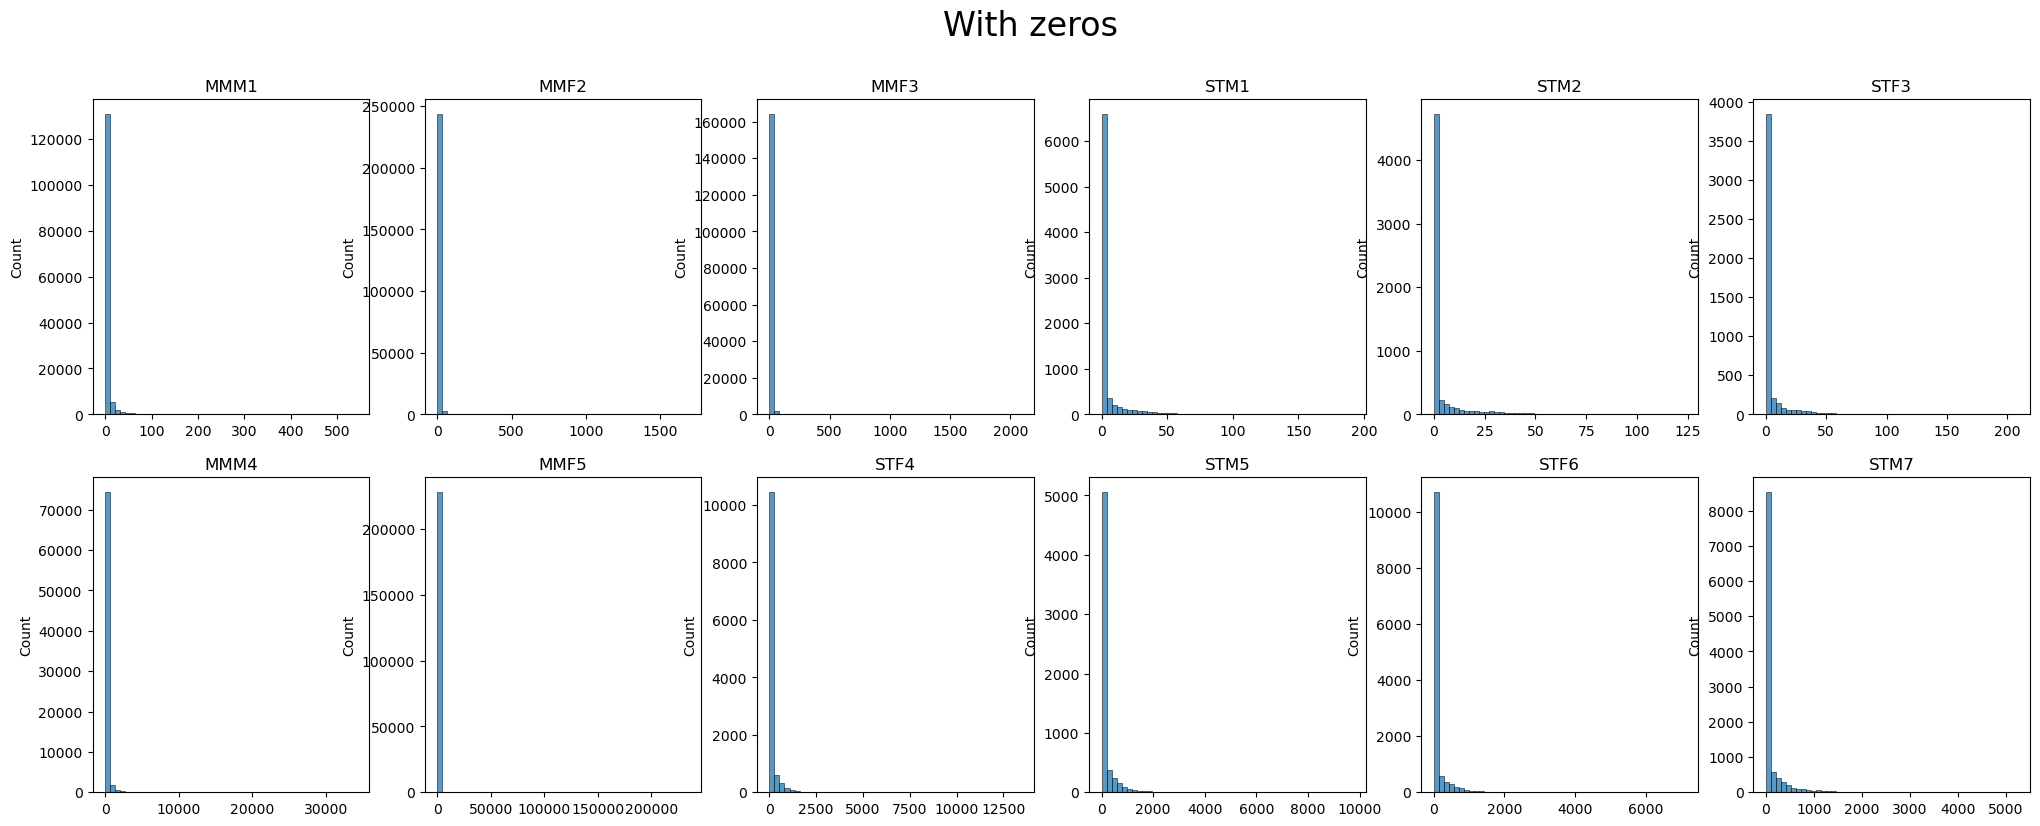

In [13]:
# plot histogram of count values
fig, axs = plt.subplots(2,6, figsize=(25,9))
i=0
for ax in axs.flat:
    sns.histplot(omc_values[i], bins = 50, legend=False, ax=ax)
    ax.set_title(mice[i])
    i+=1
fig.suptitle("With zeros", size=24)

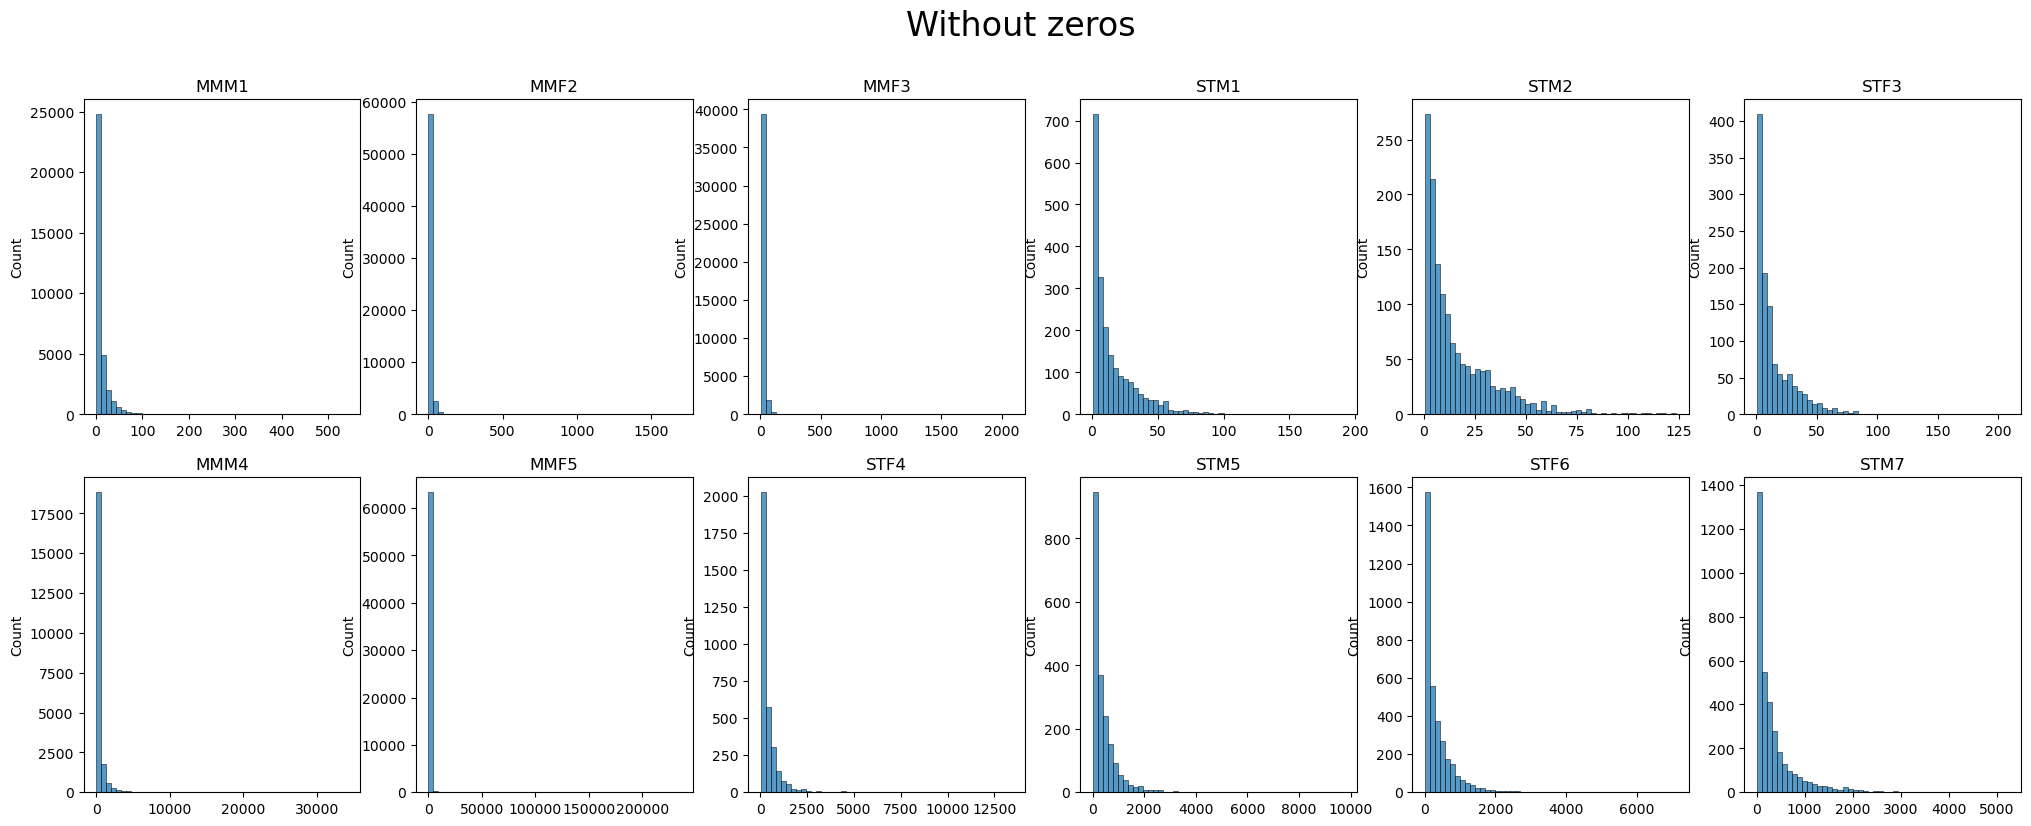

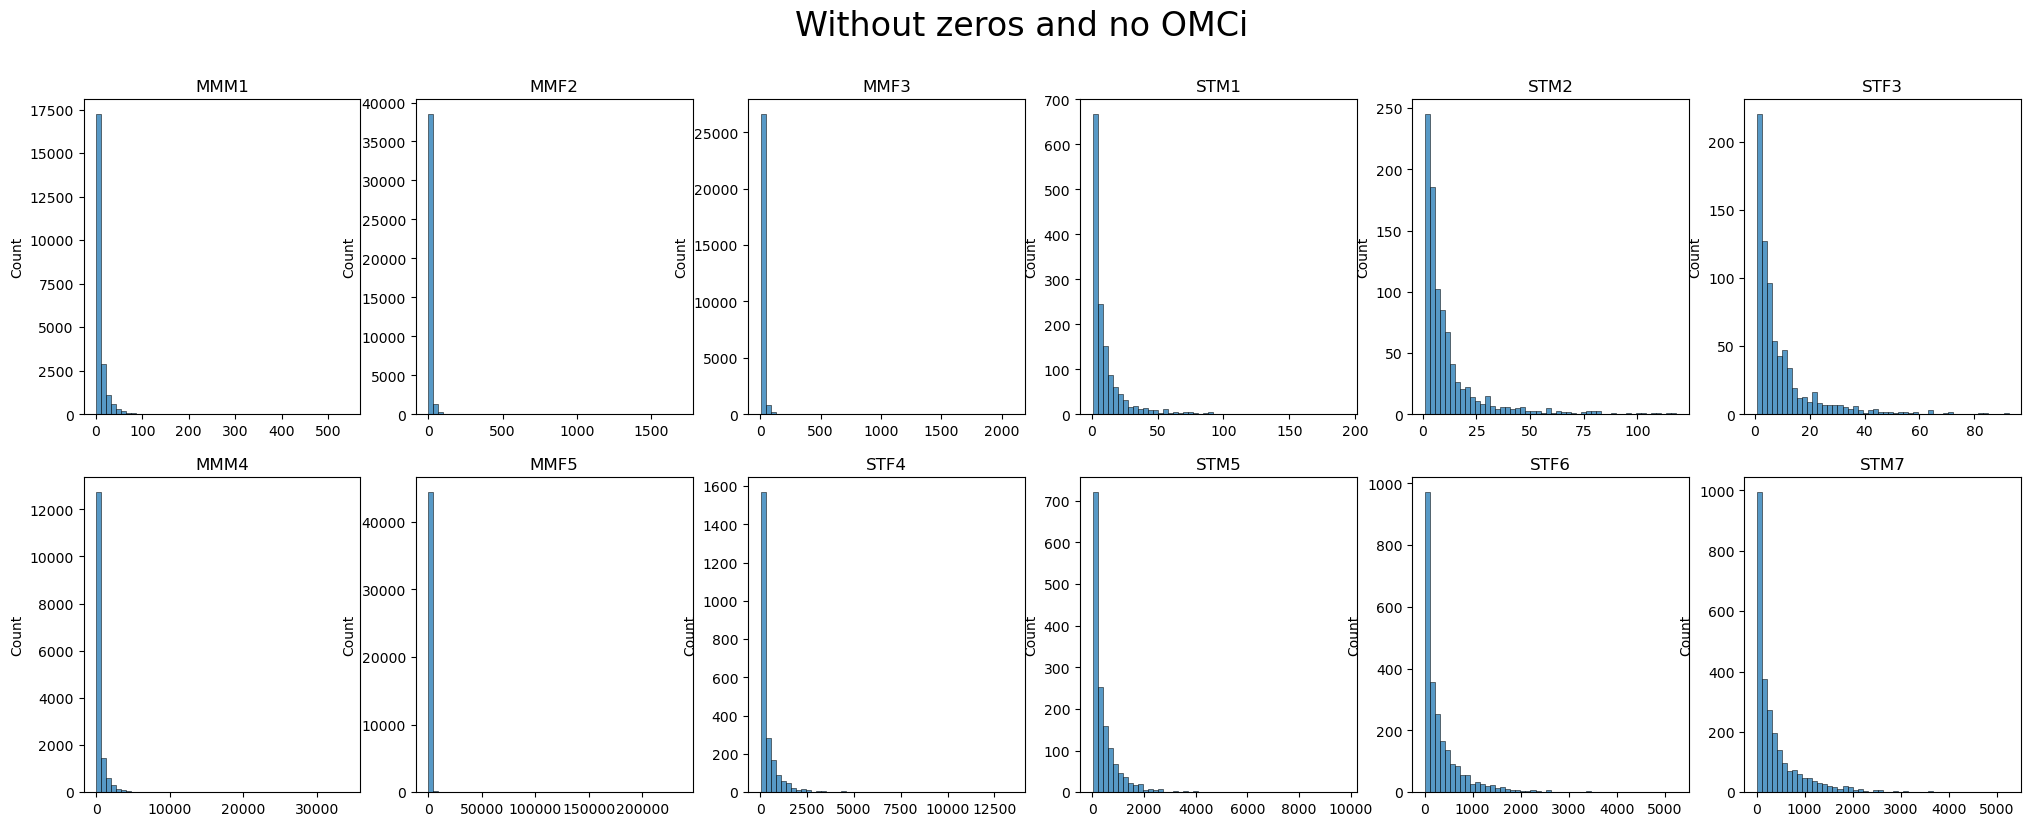

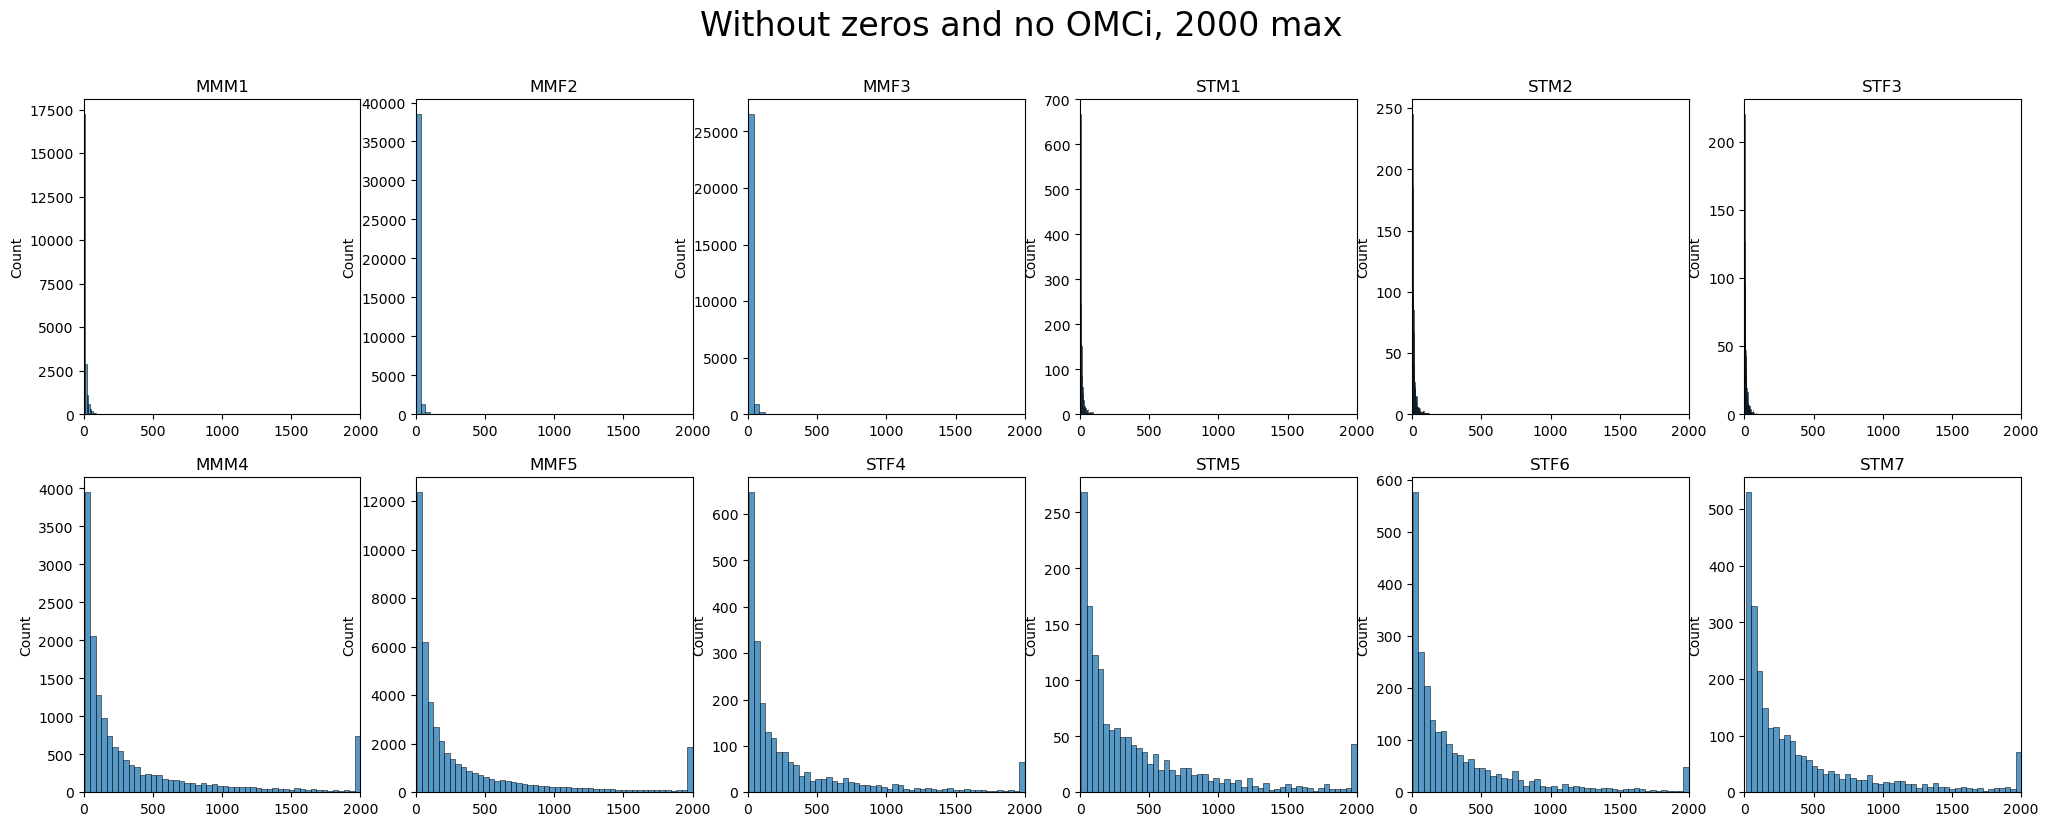

In [19]:
# plot = []
# for i in range(num_samples):
#     plot.append(omc_values[i].nonzero())

# plot histogram of count values
fig, axs = plt.subplots(2,6, figsize=(25,9))
i=0
for ax in axs.flat:
    idx = omc_values[i].nonzero()
    plot = omc_values[i][idx]
    sns.histplot(plot, bins = 50, legend=False, ax=ax)
    ax.set_title(mice[i])
    i+=1
fig.suptitle("Without zeros", size=24)
plt.show()

# drop OMCi
fig, axs = plt.subplots(2,6, figsize=(25,9))
i=0
for ax in axs.flat:
    df = omc_countN[i].drop("OMCi", axis=1)
    vals = df.values.flatten()
    idx = vals.nonzero()
    plot = vals[idx]
    sns.histplot(plot, bins = 50, legend=False, ax=ax)
    ax.set_title(mice[i])
    i+=1
fig.suptitle("Without zeros and no OMCi", size=24)
plt.show()

# create cut-off so histograms on similar scale
fig, axs = plt.subplots(2,6, figsize=(25,9))
i=0
for ax in axs.flat:
    df = omc_countN[i].drop("OMCi", axis=1)
    vals = df.values.flatten()
    idx = vals.nonzero()
    plot = vals[idx]
    plot[plot > 2000] = 2000
    sns.histplot(plot, bins = 50, legend=False, ax=ax)
    ax.set_title(mice[i])
    ax.set_xlim(0,2000)
    i+=1
fig.suptitle("Without zeros and no OMCi, 2000 max", size=24)
plt.show()

# Aggregate data

In [20]:
omc_mm = []
omc_st = []
for i in range(num_samples):
    if species[i] == "MMus":
        omc_mm.append(omc_countN[i])
    else:
        omc_st.append(omc_countN[i])

omc_mm_all = pd.concat(omc_mm)
omc_st_all = pd.concat(omc_st)

# Covariance/correlation

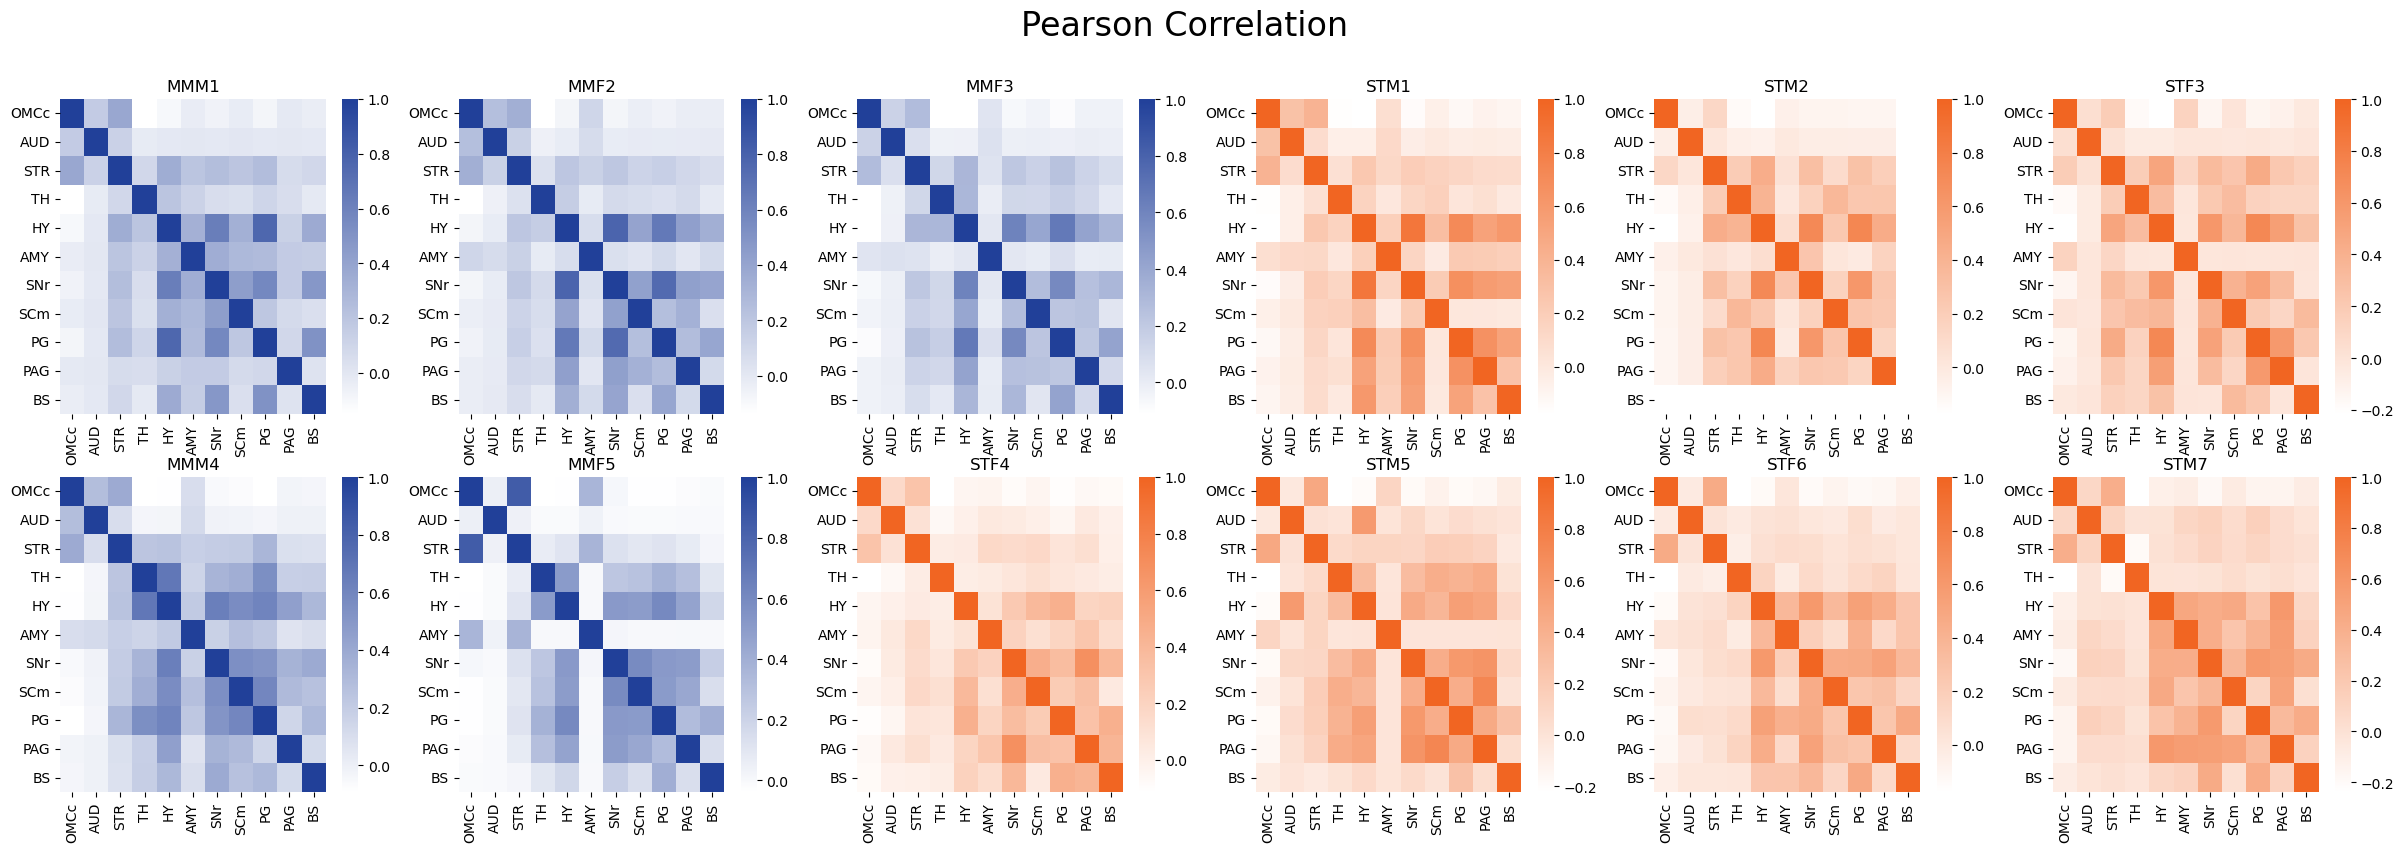

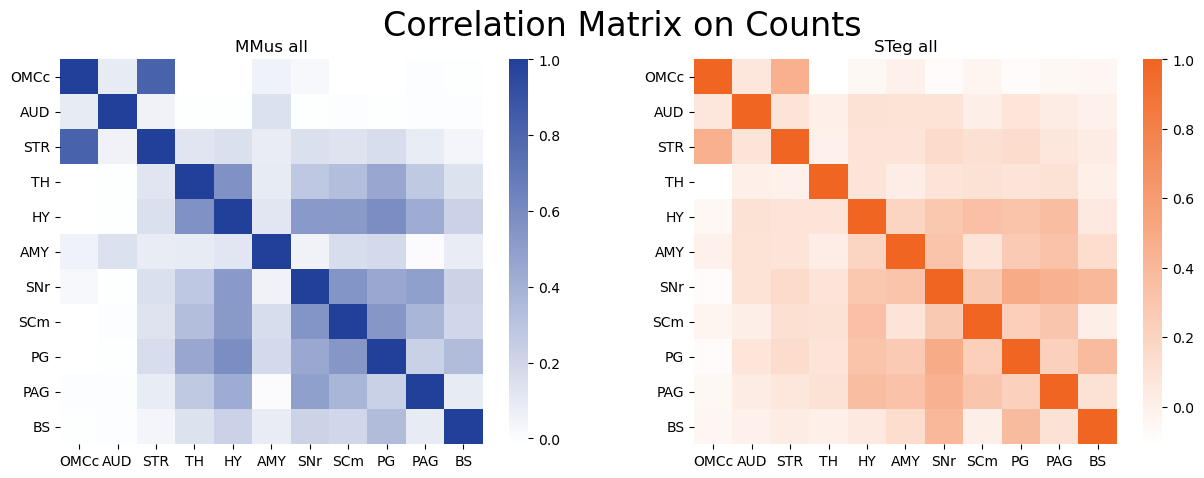

In [23]:

# correlation plots
fig, axs = plt.subplots(2, 6, figsize=(30,9))
i=0
for ax in axs.flat:
    df = omc_countN[i].drop("OMCi", axis=1)
    if species[i]=="MMus":
        sns.heatmap(df.corr(), cmap=blue_cmp, ax=ax)
    else:
        sns.heatmap(df.corr(), cmap=orange_cmp, ax=ax)
    ax.set_title(mice[i])
    
    i+=1
plt.suptitle("Pearson Correlation",size=24)
plt.show()



# aggregated correlation plots
fig, axs = plt.subplots(1,2, figsize=(15,5))

sns.heatmap(omc_mm_all.drop("OMCi", axis=1).corr(), cmap=blue_cmp, ax=axs[0])
axs[0].set_title("MMus all")

sns.heatmap(omc_st_all.drop("OMCi", axis=1).corr(), cmap=orange_cmp, ax=axs[1])
axs[1].set_title("STeg all")

plt.suptitle("Correlation Matrix on Counts",size=24)
plt.show()


# PCA

In [29]:
sorted = [sort_by_celltype(df, pt_areas=["AMY", "SNr", "SCm", "PG", "PAG", "BS"]) for df in omc_countN]

omc_mm_sort = []
omc_st_sort = []
for i in range(num_samples):
    if species[i] == "MMus":
        omc_mm_sort.append(sorted[i])
    else:
        omc_st_sort.append(sorted[i])

sorted_mm_all = pd.concat(omc_mm_sort)
sorted_st_all = pd.concat(omc_st_sort)


(71594, 12)
(71594, 12)
10      53520
100      9583
1000     8491
Name: type, dtype: int64


<AxesSubplot: xlabel='C0', ylabel='C1'>

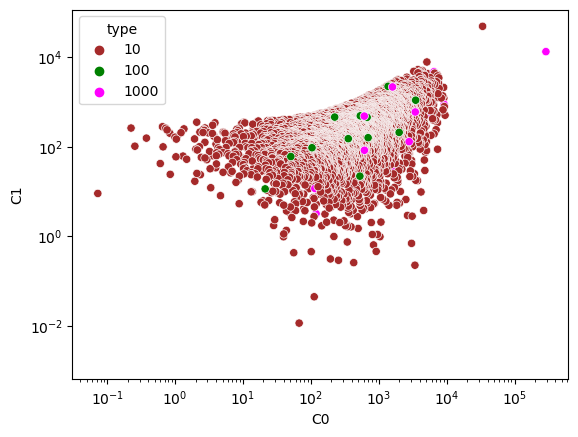

In [51]:
# create PCA component labels
com_labels = []
for i in range(12):
    com_labels.append('C'+str(i))

# specify colors for cell types
color_dict = {10:'brown', 100:'green', 1000:'magenta'}

pca = PCA()
mm_type = sorted_mm_all['type'].reset_index(drop=True)
mm_plot = sorted_mm_all.drop("type", axis=1)
components = pca.fit_transform(mm_plot)
print(mm_plot.shape)
print(components.shape)
components[:,0].shape
plot = pd.DataFrame(components, columns = com_labels)
plot['type'] = mm_type

print(mm_type.value_counts())


g = sns.scatterplot(plot, x="C0", y="C1", hue="type", palette=color_dict)
g.set(xscale='log', yscale='log')
g


In [59]:
com_var = pca.explained_variance_ratio_
for i in range(com_var.shape[0]):
    print(com_labels[i], "\t", com_var[i]*100)

C0 	 86.29967896217123
C1 	 7.969536969845119
C2 	 2.835963179868398
C3 	 1.266765870269579
C4 	 1.1864539024801068
C5 	 0.1918229028299371
C6 	 0.13822015167608712
C7 	 0.04648961988229671
C8 	 0.030033577461432044
C9 	 0.020431818594699603
C10 	 0.013413667372544699
C11 	 0.0011893775485476371


In [41]:
print(plot.shape)
mm_type

(71594, 12)


0          10
1          10
2          10
3          10
4          10
         ... 
18990    1000
18991    1000
18992    1000
18993    1000
18994    1000
Name: type, Length: 71594, dtype: int64